# **Count MNIST**

---

Designing a convolutional network for counting the handwritten
digits in an image. 

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

base_dir_drive = '/content/drive/My Drive/CountMNIST'

In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import cv2 as cv
from google.colab.patches import cv2_imshow
import os
import pickle

### **Loading the data**

In [0]:
mnist_dir_path = os.path.join(base_dir_drive, 'Data')

with open(os.path.join(mnist_dir_path, 'mnist_count_train.pickle'), mode='rb') as file:
  count_train_set = pickle.load(file)
with open(os.path.join(mnist_dir_path, 'mnist_count_test.pickle'), mode='rb') as file:
  count_test_set = pickle.load(file)

### **Data analysis**

#### **Dataset Description**   
  

---

  
The ***training set*** consists of 5000 images and the number of digits in each image.   
The ***testing set*** consists of 1000 images and the number of digits in each image. 

The size of each of the images is 100x100 pixels.  
The images are formed by placing N (1 to 5) digits from the MNIST dataset(28x28 digits) onto a noisy background.

In [0]:
print('Train_set info'.upper())
print('-'*60)
print('     Type : ', type(count_train_set))
print('     Keys : ', list(count_train_set.keys()))

print(' -Images info :'.upper())
print('     Size : ', count_train_set['images'].shape)

print(' -No_count info :'.upper())
print('     Size : ', count_train_set['no_count'].shape)
print('      Min : ', int(np.min(count_train_set['no_count'])))
print('      Max : ', int(np.max(count_train_set['no_count'])))

print('\n')

print('Test_set info'.upper())
print('-'*60)
print('     Type : ', type(count_test_set))
print('     Keys : ', list(count_test_set.keys()))

print(' -Images info :'.upper())
print('     Size : ', count_test_set['images'].shape)

print(' -No_count info :'.upper())
print('     Size : ', count_test_set['no_count'].shape)
print('      Min : ', int(np.min(count_test_set['no_count'])))
print('      Max : ', int(np.max(count_test_set['no_count'])))

TRAIN_SET INFO
------------------------------------------------------------
     Type :  <class 'dict'>
     Keys :  ['images', 'coords', 'no_count']
 -IMAGES INFO :
     Size :  (5000, 100, 100)
 -NO_COUNT INFO :
     Size :  (5000,)
      Min :  1
      Max :  5


TEST_SET INFO
------------------------------------------------------------
     Type :  <class 'dict'>
     Keys :  ['images', 'coords', 'no_count']
 -IMAGES INFO :
     Size :  (1000, 100, 100)
 -NO_COUNT INFO :
     Size :  (1000,)
      Min :  1
      Max :  5


####**Defining the tools used in plotting**

---



Creating the fonts and colors that will be used in plots.  
>Importing *consolas* font for text in plots.  
>Defining the color scheme for plots.  
>Defining functions for plot axes format

In [0]:
import matplotlib.font_manager as fm

# Download 'consolas' font from url, unzip it and move it
# Imported 'consolas' font will be located in 'fonts' directory of the current notebook
!wget "https://fontsnetwork.com/download/consolas" -O "/content/consolas.zip"
!unzip "/content/consolas.zip" -d "/content/consolas"
!mv "/content/consolas/" "/usr/share/fonts/truetype/consolas/"
!rm "/content/consolas.zip"

In [0]:
regular_font_path = '/usr/share/fonts/truetype/consolas/CONSOLA.TTF'
bold_font_path = '/usr/share/fonts/truetype/consolas/CONSOLAB.TTF'

# Defining fonts properties used for different text types in plots
title_fontL = fm.FontProperties(fname=regular_font_path)
title_fontL.set_size(14)
title_fontL.set_style('normal')
title_fontM = fm.FontProperties(fname=regular_font_path)
title_fontM.set_size(12)
title_fontM.set_style('normal')
title_fontS = fm.FontProperties(fname=regular_font_path)
title_fontS.set_size(10)
title_fontS.set_style('normal')

labels_font = fm.FontProperties(fname=regular_font_path)
labels_font.set_size(11)
labels_font.set_style('normal')

text_font = fm.FontProperties(fname=bold_font_path)
text_font.set_size(9)
text_font.set_style('normal')

In [0]:
class PlotColorScheme:
  def __init__(self):
    self.light_2 = (238/255, 69/255, 64/255)
    self.light_1 = (199/255, 44/255, 65/255)
    self.middle = (128/255, 19/255, 54/255)
    self.dark_1 = (81/255, 10/255, 50/255)
    self.dark_2 = (45/255, 20/255, 44/255)

plot_colors = PlotColorScheme()

In [0]:
class ImageColorScheme:
  def __init__(self):
    self.light_2 = (238, 69, 64)
    self.light_1 = (199, 44, 65)
    self.middle = (128, 19, 54)
    self.dark_1 = (81, 10, 50)
    self.dark_2 = (45, 20, 44)

img_colors = ImageColorScheme()

In [0]:
def no_spines_plot(axis):
  axis.spines["top"].set_visible(False)
  axis.spines["right"].set_visible(False)
  axis.spines["bottom"].set_visible(False)
  axis.spines["left"].set_visible(False)  

In [0]:
def no_ticks_plot(axis):
  axis.set_xticks([])
  axis.set_yticks([])

#### **Data Visualization**

---

Plotting a subset of 10 images selected randomly from the training set. 
Displaying the correct number of digits in each image.

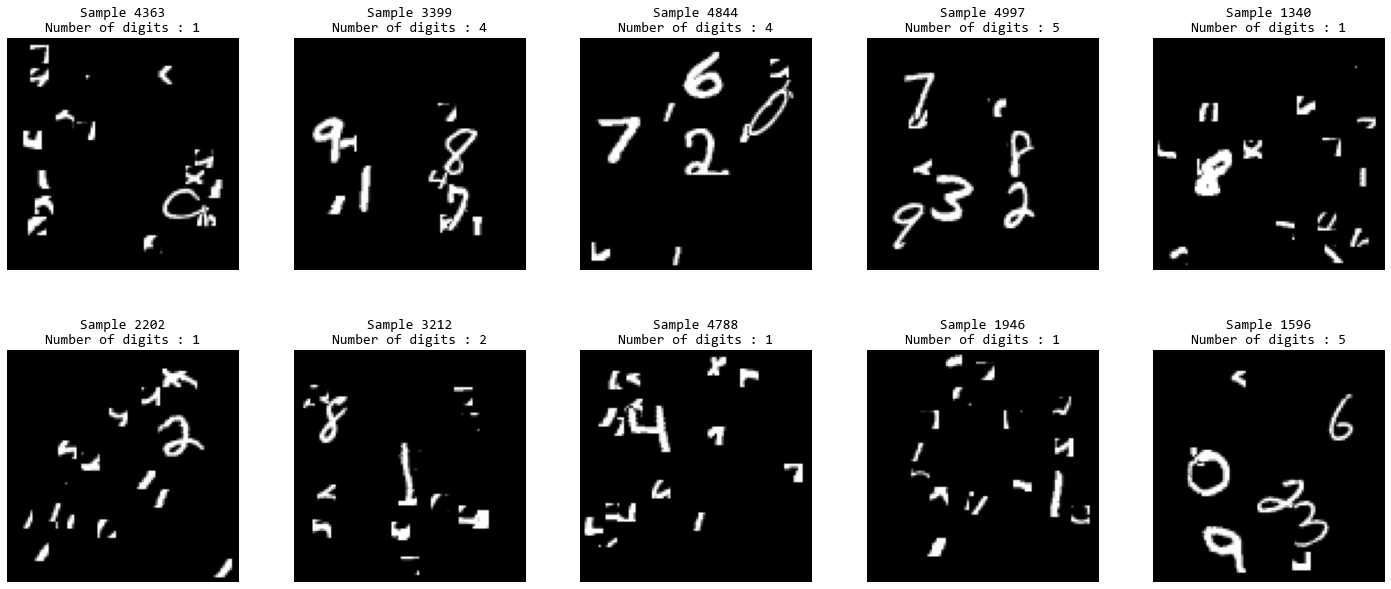

In [0]:
train_images = count_train_set['images']
train_count = count_train_set['no_count']

plot_idx = np.random.randint(5000, size=10)
plot_images = train_images[plot_idx, :, :]
plot_count = train_count[plot_idx]

fig, ax = plt.subplots(2, 5, figsize=(25, 10), 
                       gridspec_kw={'wspace': .15, 'hspace': .35})

for i in range(10):
  ax[i//5][i%5].imshow(plot_images[i]/255, cmap='gray', vmin=0, vmax=1)

  no_spines_plot(ax[i//5][i%5])
  no_ticks_plot(ax[i//5][i%5])

  ax[i//5][i%5].set_title('Sample ' + str(plot_idx[i]+1) +\
                          '\nNumber of digits : ' + str(int(plot_count[i])),
                          fontproperties=title_fontL)
plt.box(None)

### **Prepare training**

---

Defining the training settings

In [0]:
kwargs={}
class Args():
  def __init__(self):
    self.batch_size = 64
    self.test_batch_size = 64
    self.epochs = 10
    self.count_epochs = 20
    self.lr = 0.01
    self.count_lr = 0.001
    self.momentum = 0.9
    self.seed = 1
    self.log_interval = int(10000 / self.batch_size)
    self.count_log_interval = int(1000 / self.batch_size)
    self.cuda = False

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### **Data Preprocessing**



---


* Reshape loaded data to match the classifier input shape
* Convert reshaped data to type ***tensor***

In [0]:
def array_to_tensor(count_set, set_type='train'):
  print('%5s SET : ' % set_type.upper())
  count_data = np.expand_dims(count_set['images'], 1)
  count_labels = count_set['no_count'].astype(np.float32)
  print('   Data Shape Transform : %s  -->  %s' % (str(count_set['images'].shape), str(count_data.shape)))

  count_data_tensor, count_labels_tensor = map(torch.tensor, (count_data, count_labels))
  print('   Data Type Transform : %s  -->  %s\n'% (str(type(count_data)), str(type(count_data_tensor))))

  return count_data_tensor, count_labels_tensor

In [0]:
count_tensor_train_data, count_tensor_train_labels = array_to_tensor(count_train_set)
count_tensor_test_data, count_tensor_test_labels = array_to_tensor(count_test_set, set_type='test')

TRAIN SET : 
   Data Shape Transform : (5000, 100, 100)  -->  (5000, 1, 100, 100)
   Data Type Transform : <class 'numpy.ndarray'>  -->  <class 'torch.Tensor'>

 TEST SET : 
   Data Shape Transform : (1000, 100, 100)  -->  (1000, 1, 100, 100)
   Data Type Transform : <class 'numpy.ndarray'>  -->  <class 'torch.Tensor'>





---


* Normalize data  
$\hspace{10mm}$Scaling pixels values to be in range $[0, 1]$

In [0]:
def normalize_data(data, set_type='train'):
  norm_data = data.float() / 255.0
  print('%5s SET : ' % set_type.upper())
  print('   Data values Rescale :[%d .. %d] -->  [%.1f .. %.1f]' % 
        (torch.min(data), torch.max(data), torch.min(norm_data), torch.max(norm_data)))

  return norm_data

In [0]:
count_norm_train_data = normalize_data(count_tensor_train_data)
count_norm_test_data = normalize_data(count_tensor_test_data, 'test')

TRAIN SET : 
   Data values Rescale :[0 .. 255] -->  [0.0 .. 1.0]
 TEST SET : 
   Data values Rescale :[0 .. 255] -->  [0.0 .. 1.0]




---


* Creating ***Dataset*** from normalized data
* Creating ***DataLoader*** from the dataset-format data

In [0]:
def data_to_dataloader(data, labels, args, shuffle=False):
  count_dataset = TensorDataset(data, labels)
  count_dataloader = DataLoader(count_dataset, batch_size=args.batch_size, shuffle=shuffle)
  
  return count_dataloader

In [0]:
count_dataloader_train = data_to_dataloader(count_norm_train_data, count_tensor_train_labels, args, shuffle=True)
count_dataloader_test = data_to_dataloader(count_norm_test_data, count_tensor_test_labels, args)

## **Method 1** : Without training on the counting dataset.

### **MNIST Classification**

---

**Experiments for MNIST Classification CNN architecture**  
  
Base CNN for classification problem and equivalent F-CNN for counting problem statistics :  
  

Model | Classification Accuracy | Count Accuracy  
--- | --- | ---  
CNN v.1| $\hspace{13mm}$99.03% | $\hspace{7mm}$35.40%  
CNN v.2 | $\hspace{13mm}$98.90% | $\hspace{7mm}$31.50%  
CNN v.3 | $\hspace{13mm}$99.40% | $\hspace{7mm}$20.40%  
  
<img src="https://drive.google.com/uc?id=1_Wn5AnBVuKNAnRsvnmP5wEeFliz-3FHm" width=900 height=800>

For this method I used **`CNN v.1`** architecture, which gave the best results for the counting problem.

In [0]:
num_filters1 = 20
num_filters2 = 50
num_neurons1 = 500
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, num_filters1, 5, 1)
    self.conv2 = nn.Conv2d(num_filters1, num_filters2, 5, 1)
    self.fc1 = nn.Linear(in_features = 4 * 4 * num_filters2, out_features = num_neurons1)
    self.fc2 = nn.Linear(in_features = num_neurons1, out_features = 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*num_filters2)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    
    return F.log_softmax(x, dim=1)

Loading the MNIST dataset with  $\scriptsize{(1\mathrm{x}28\mathrm{x}28)}$ images.

In [0]:
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=True, download=True,
                 transform=transforms.Compose([transforms.ToTensor(), ])),
                 batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=False, 
                 transform=transforms.Compose([transforms.ToTensor(), ])),
                 batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

Plotting a subset of 10 images selected randomly from the training set. 

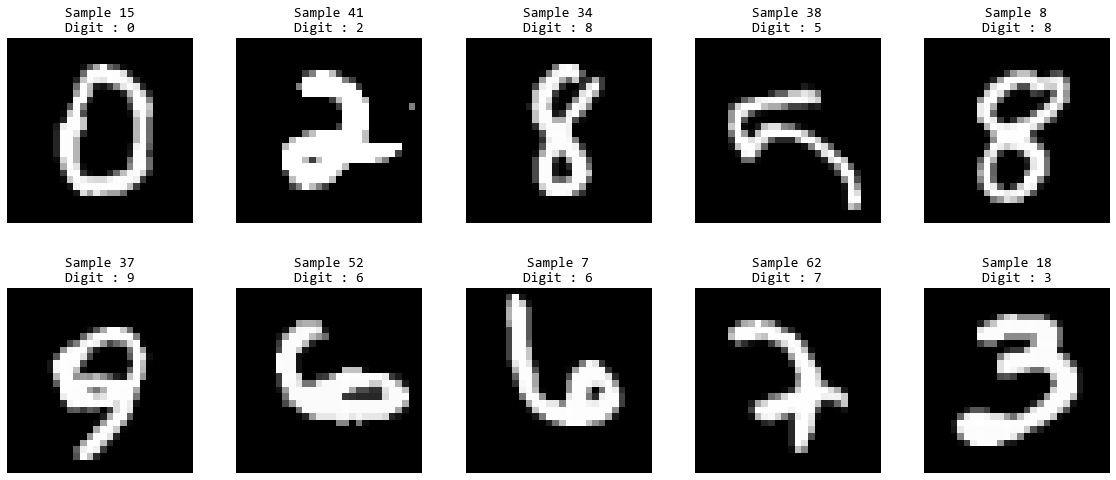

In [0]:
plot_batch_images, plot_batch_labels = next(iter(train_loader))

plot_idx = np.random.randint(args.batch_size, size=10)
plot_images = plot_batch_images[plot_idx].squeeze()
plot_labels = plot_batch_labels[plot_idx]

fig, ax = plt.subplots(2, 5, figsize=(20, 8), 
                       gridspec_kw={'wspace': .15, 'hspace': .35})

for i in range(10):
  ax[i//5][i%5].imshow(plot_images[i], cmap='gray', vmin=0, vmax=1)

  no_spines_plot(ax[i//5][i%5])
  no_ticks_plot(ax[i//5][i%5])

  ax[i//5][i%5].set_title('Sample ' + str(plot_idx[i]+1) +\
                          '\nDigit : ' + str(int(plot_labels[i])),
                          fontproperties=title_fontL)
plt.box(None)

Defining functions for training and testing.

In [0]:
def train(args, model, device, train_loader, optimizer, epoch):
  model.train()
  batch_loss = []
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    
    optimizer.zero_grad()
    
    output = model(data)
    loss = F.nll_loss(output, target)
    
    loss.backward()
    batch_loss.append(loss.data.cpu().numpy())

    optimizer.step()
    
    if batch_idx % args.log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
      
  return np.array(batch_loss).mean()
            

def test(args, model, device, test_loader):
  model.eval()

  correct = 0
  test_loss = 0

  with torch.no_grad():
    num_iter = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      
      output = model(data)
      test_loss += F.nll_loss(output, target)
      
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).float().mean().item()
      num_iter += 1

  test_loss /= num_iter

  print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.4f}%)\n'.format(
      test_loss, 100. * correct / num_iter))
    
  return test_loss, 100. * correct / num_iter

In [0]:
model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

train_total_loss = []
test_total_loss = []
test_accuracy = []

for epoch in range(1, args.epochs + 1):
  train_loss = train(args, model, device, train_loader, optimizer, epoch)
  test_loss, epoch_acc = test(args, model, device, test_loader)
  train_total_loss.append(train_loss)
  test_total_loss.append(test_loss)
  test_accuracy.append(epoch_acc)
  
torch.save(model.state_dict(), os.path.join(base_dir_drive, 'Models/mnist_cnn1.pt'))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317908
Train Epoch: 1 [9984/60000 (17%)]	Loss: 0.231059
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.072034
Train Epoch: 1 [29952/60000 (50%)]	Loss: 0.042297
Train Epoch: 1 [39936/60000 (67%)]	Loss: 0.104197
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.018496
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.051971

Test set: Average loss: 0.0789, Accuracy: (97.4359%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.119329
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.053383
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.019356
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.017492
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.084315
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.052332
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.014789

Test set: Average loss: 0.0519, Accuracy: (98.3073%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022908
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.053917
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.086512
Train Epoch: 3 [29952/60000 (50%)]	Loss: 0.020680
Train 

In [0]:
save_performance_path = os.path.join(base_dir_drive, 'Models')
np.save(os.path.join(save_performance_path, 'train_loss_cnn1.npy'), 
        np.array(train_total_loss))
np.save(os.path.join(save_performance_path, 'test_loss_cnn1.npy'), 
        np.array(test_total_loss))
np.save(os.path.join(save_performance_path, 'test_acc_cnn1.npy'), 
        np.array(test_accuracy))

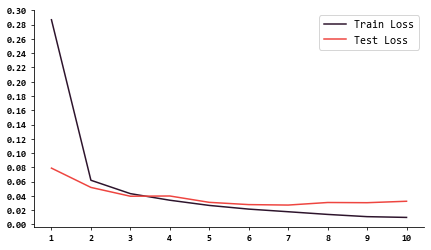

In [0]:
fig = plt.figure(figsize=(7, 4))
ax = plt.axes()

train_plot = plt.plot(train_total_loss, color=plot_colors.dark_2)
test_plot = plt.plot(test_total_loss, color=plot_colors.light_2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

x_ticks = list(range(0, args.epochs))
ax.set_xticks(x_ticks)
ax.set_xticklabels([t+1 for t in x_ticks], fontproperties=text_font)
ylim = ax.get_ylim()
y_ticks = np.arange(0, ylim[1], .02)
ax.set_yticks(y_ticks)
ax.set_yticklabels([str('{:1.2f}'.format(tick)) for tick in y_ticks],
                   fontproperties=text_font)
ax.tick_params(axis='both', color='black', length=3, width=.75)

legend = ax.legend(['Train Loss', 'Test Loss'], prop=labels_font)

 ### **Maps prediction approach**

---


Converting a model trained to classify images on MNIST dataset into a fully convolutional network to predict maps representing the probability of digits being present at that location.  
Using these maps to predict the number of digits in the image.  

##### **Defining the FCNN model**  

---


We will use the parameters from the already trained CNN model for the MNIST classification problem.
> The Fully-Connected layers in the CNN will be transformed in Convolutional layers

In [0]:
class FCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, num_filters1, 5, 1)
    self.conv2 = nn.Conv2d(num_filters1, num_filters2, 5, 1)
    self.fully_conv1  = nn.Conv2d(num_filters2, num_neurons1, 4)
    self.fully_conv2 = nn.Conv2d(num_neurons1, 10, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.fully_conv1(x))
    x = self.fully_conv2(x)
    return F.log_softmax(x, dim=1)

Checking the CNN parameters dimensions:

In [0]:
print(' MNIST Classification model :')
print('-'*30)
for name, param in model.state_dict().items():
  print('%15s :   %s' % (name, str(tuple(param.shape))))

 MNIST Classification model :
------------------------------
   conv1.weight :   (20, 1, 5, 5)
     conv1.bias :   (20,)
   conv2.weight :   (50, 20, 5, 5)
     conv2.bias :   (50,)
     fc1.weight :   (500, 800)
       fc1.bias :   (500,)
     fc2.weight :   (10, 500)
       fc2.bias :   (10,)


Reshaping the parameters from the Fully-Connected layers in the CNN to be used as filters for the Fully-Convolutional layers.  

In [0]:
fcnn_model_path = os.path.join(base_dir_drive, 'Models/mnist_fcnn1.pt')
torch.save(model.state_dict(), fcnn_model_path)
model_fcnn_state_dict = torch.load(fcnn_model_path)

model_fcnn = FCNN()
model_fcnn_dict = {}

print(' Fully convolutional model Transform : ')
print('-'*40)
for key, param in model_fcnn_state_dict.items():
  if 'fc' in key:
    if 'weight' in key:
      print('   %s' % key.strip('.weight').upper(), end='  -->')
    key = key.replace('fc', 'fully_conv')
    if 'weight' in key:
      print('   %s' % key.strip('.weight').upper(), end='   |')
    if 'fully_conv1.weight' in key:
      print('   %10s' % str(tuple(param.shape)), end='  -->')
      param = param.view(-1, num_filters2, 4, 4)
      print('   %s' % str(tuple(param.shape)))
    if 'fully_conv2.weight' in key:
      print('   %10s' % str(tuple(param.shape)), end='  -->')
      param = param.view(-1, num_neurons1, 1, 1)
      print('   %s' % str(tuple(param.shape)))
  model_fcnn_dict[key] = param

model_fcnn.load_state_dict(model_fcnn_dict)
torch.save(model_fcnn_dict, fcnn_model_path)
model_fcnn = model_fcnn.to(device)

 Fully convolutional model Transform : 
----------------------------------------
   FC1  -->   FULLY_CONV1   |   (500, 800)  -->   (500, 50, 4, 4)
   FC2  -->   FULLY_CONV2   |    (10, 500)  -->   (10, 500, 1, 1)


##### **Deciding on the threshold value**

---

We know that the minimum number of digits in an image is 1.  
This means that the position that holds the maximum score over all activation maps corresponds to the position of a digit in the input image.  
> $\small{(x_{\scriptsize{MAX}},\ y_{\scriptsize{MAX}}) \hspace{5mm}\rightarrow \hspace{5mm} Score_{\scriptsize{MAX}}}$  
  
We will use this fact and define an evaluation method w.r.t. $\small{Score_{\scriptsize{MAX}}}$.
> $\small{Score_{\scriptsize{MAX}}\ -\ max_{\scriptsize{map\ }_{\large{i}}}}$
$\hspace{10mm}
\small{
\left.
\begin{array}{ll} 
\scriptsize{i\ =\ 1\ ..\ 10}\\
\scriptsize{max_{\scriptsize{map\ }_{\large{i}}}\ -\ maximum\ value\ in\ activation\ map\ \bf{i}}\\ 
\end{array}
\right.}$



---

We notice that applying a **`threshold = 4e-5`** gives a count of digits close to the real count.  


<img src="https://drive.google.com/uc?id=1FsfLSGt4isCcG4jcH_j10LjIKkiYt38D">

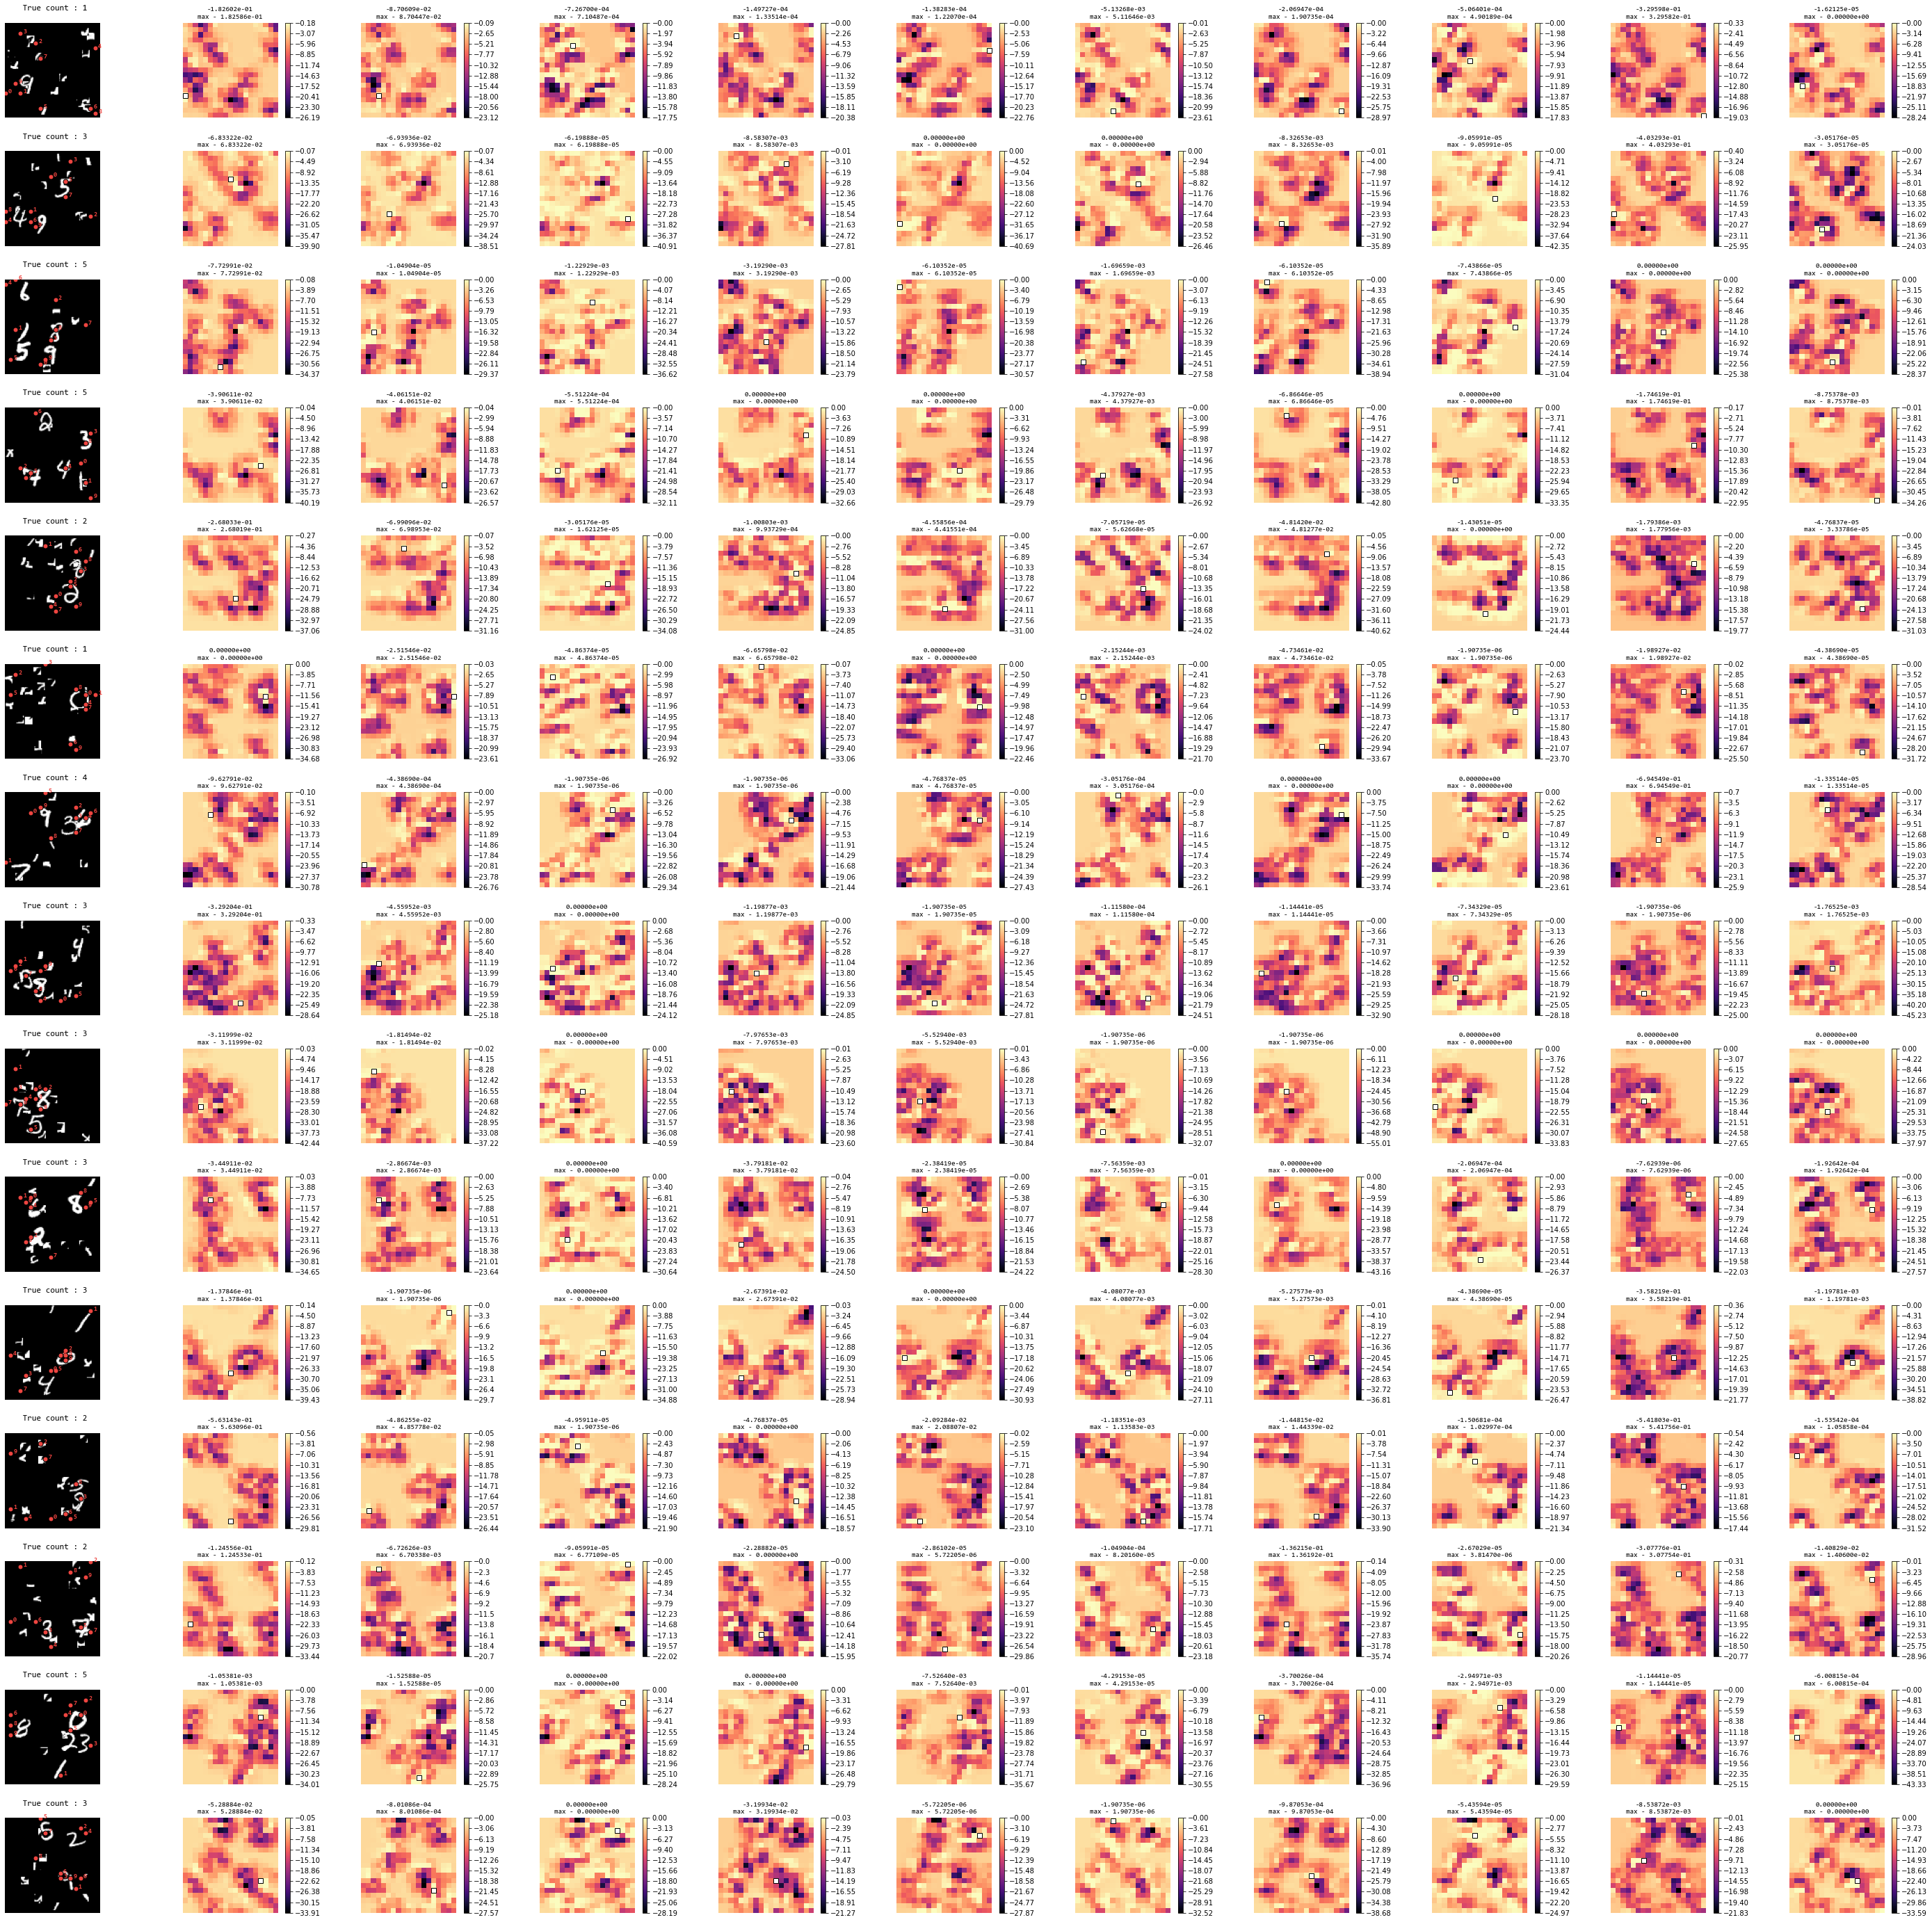

In [0]:
num_batches = len(count_dataloader_test) - 1
plot_idx = np.random.randint(args.batch_size, size=num_batches)

fig, ax = plt.subplots(num_batches, 11, figsize=(50, 50),
                       gridspec_kw={'wspace': .15, 'hspace': .35})

for batch_idx, (count_images, target) in enumerate(count_dataloader_test):   
  cuda_images = count_images.to(device)
  out_act_maps = model_fcnn(cuda_images).cpu().detach().numpy()

  if batch_idx < num_batches:
    image = out_act_maps[plot_idx[batch_idx]]

    max_img = np.max(image)
    img_max_idx = []
    img_max_scores = []

    ax[batch_idx,0].imshow(count_images[plot_idx[batch_idx], 0], cmap='gray')
    no_spines_plot(ax[batch_idx, 0])
    no_ticks_plot(ax[batch_idx, 0])
    
    for m in range(10):

      act_map = image[m]

      max_idx_map = np.argmax(act_map)
      max_score_map = np.max(act_map)
      min_score_map = np.min(act_map)

      img_max_idx.append(max_idx_map)
      img_max_scores.append(max_score_map)
      
      max_coord = [max_idx_map%19, max_idx_map//19]
      plot_map = ax[batch_idx, m+1].imshow(act_map, cmap='magma')
      ax[batch_idx, m+1].plot(max_coord[0], max_coord[1], marker='s',markersize=7,
                                     markerfacecolor='white', markeredgecolor='black')      
        
      bar_ticks = np.linspace(min_score_map, max_score_map, 10, endpoint=True)
      fig.colorbar(plot_map, ax=ax[batch_idx,m+1], ticks=bar_ticks)
        
      no_spines_plot(ax[batch_idx, m+1])
      no_ticks_plot(ax[batch_idx, m+1])

      plot_score = '{:.5e}'.format(max_score_map)
      plot_rel_score = '\nmax - ' + '{:.5e}'.format(max_img - max_score_map)
      plot_title = plot_score + plot_rel_score
      ax[batch_idx, m+1].set_title(plot_title, fontproperties=title_fontS)

        
      ax[batch_idx,0].plot(max_coord[0]*100/19, max_coord[1]*100/19, 
                            marker='o',markersize=7, markerfacecolor=plot_colors.light_2,
                            markeredgecolor='black')
      ax[batch_idx,0].text(max_coord[0]*100/19+3, max_coord[1]*100/19, str(m), 
                            fontproperties=text_font, fontdict={'color': plot_colors.light_2})

    true_count = ' True count : ' + str(int(target[plot_idx[batch_idx]].item()))
    plot_title = true_count + '\n'
    ax[batch_idx,0].set_title(plot_title, fontproperties=title_fontM)

plt.box(None)

fig_path = os.path.join(base_dir_drive, 'Images/10MapsFig_var1.png')
plt.savefig(fig_path, dpi=200)

##### **Defining tools for model evaluation**

In [0]:
def draw_confusion_matrix(conf_matrix, cell_dim, tp_color, fn_color):

  # Convert RGB color to BGR color to use for opencv image
  tp_color = tp_color
  fn_color = fn_color[[2, 1, 0]]
  text_scale = cv.getFontScaleFromHeight(2, cell_dim//4)

  num_labels = conf_matrix.shape[0]
  matrix_img = np.zeros((num_labels*cell_dim, num_labels*cell_dim, 3)).astype('uint8')

  # Get values range for true-positives
  tp_idx = [i for i in range(num_labels)]
  tp_values = conf_matrix[tp_idx, tp_idx]
  min_tp, max_tp = np.min(tp_values), np.max(tp_values)

  # Get values range for false-negatives
  fn_rows = [[i, i, i, i] for i in range(num_labels)]
  fn_cols = [list(range(i)) + list(range(i+1, num_labels)) for i in range(num_labels)]
  fn_values = conf_matrix[fn_rows, fn_cols]
  min_fn, max_fn =  np.min(fn_values), np.max(fn_values)

  # Create the confusion matrix diagonal with true-positives
  for i in range(num_labels):
    intensity = (conf_matrix[i, i]-min_tp) / (max_tp-min_tp) * (-.8) + 1
    cell_color =  tp_color * intensity
    matrix_img[i*cell_dim:(i+1)*cell_dim, i*cell_dim:(i+1)*cell_dim, :] = cell_color.astype('uint8')
    text_pos = (int(i*cell_dim + cell_dim/4), int(i*cell_dim + 5*cell_dim/8))
    cv.putText(matrix_img, str(tp_values[i]), text_pos, 
              fontFace=2, fontScale=text_scale, color=(255, 255, 255))

  # Create the rest of confusion matrix with false-negatives
  for i in range(5):
    for j in range(5):
      if i != j:
        intensity = (conf_matrix[i, j]-min_fn) / (max_fn-min_fn) * (-.8) + 1
        cell_color =  fn_color * intensity
        matrix_img[i*cell_dim:(i+1)*cell_dim, j*cell_dim:(j+1)*cell_dim, :] = cell_color.astype('uint8')
        text_pos = (int(j*cell_dim + cell_dim/4), int(i*cell_dim + 5*cell_dim/8))
        cv.putText(matrix_img, str(conf_matrix[i][j]), text_pos, 
                  fontFace=2, fontScale=text_scale, color=(0, 0, 0))
        
  return matrix_img

##### **Evaluating the result**



---


Plotting some input images and the corresponding counting results.

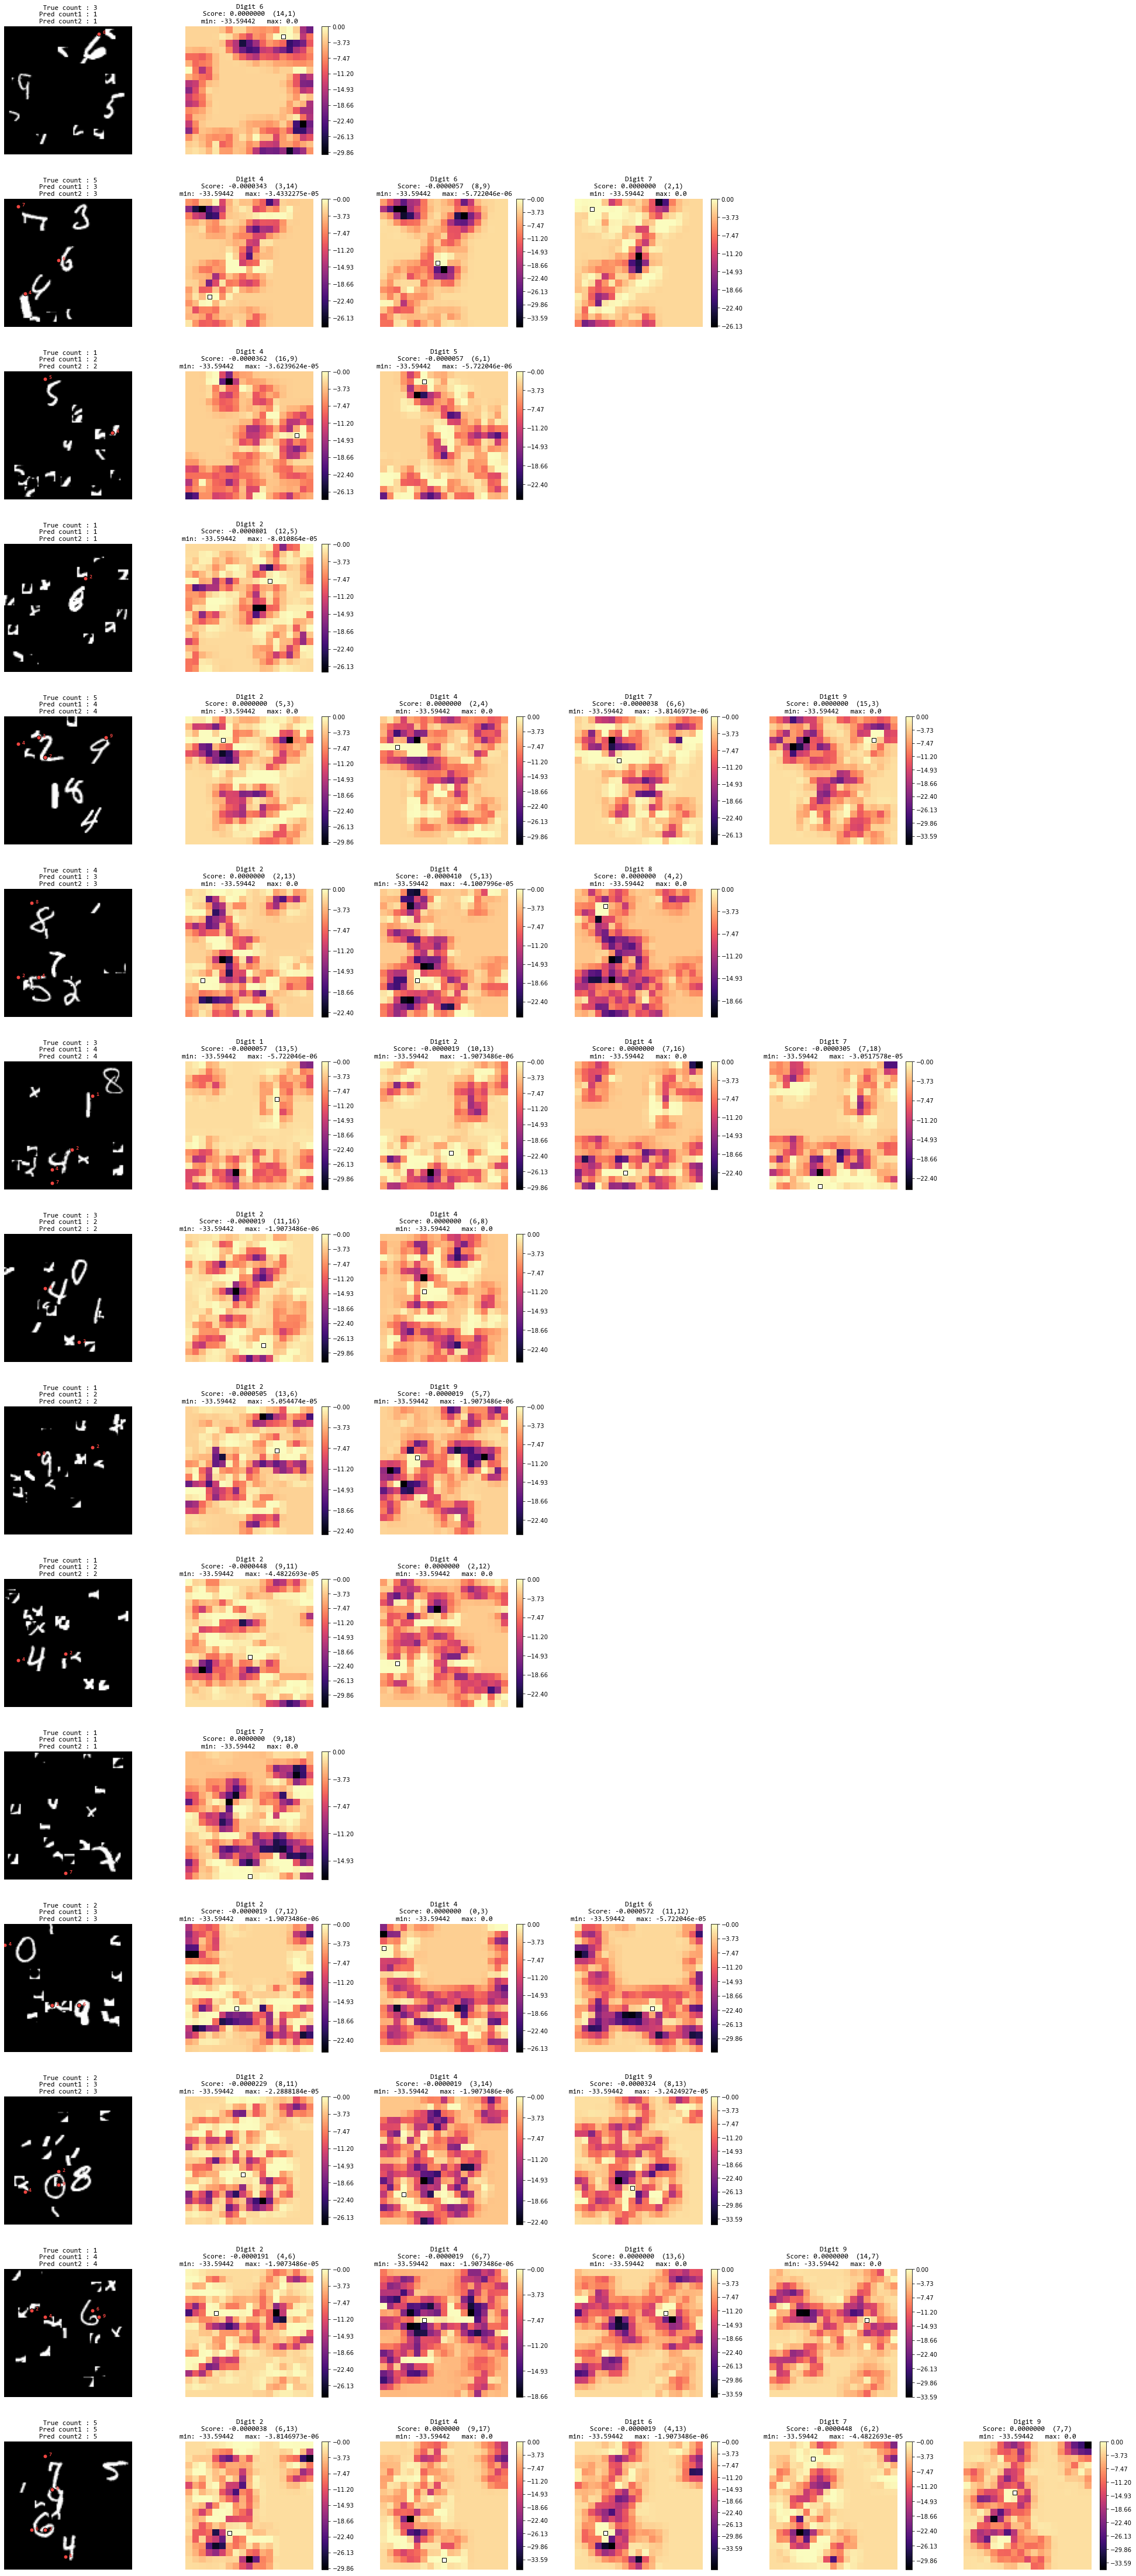

In [0]:
num_batches = len(count_dataloader_test) - 1
plot_idx = np.random.randint(args.batch_size, size=num_batches)

fig, ax = plt.subplots(num_batches, 6, figsize=(35, 80),
                       gridspec_kw={'wspace': .15, 'hspace': .35})

white_plot = np.ones((19, 19, 3))

for batch_idx, (count_images, target) in enumerate(count_dataloader_test): 
  cuda_images = count_images.to(device)
  out_act_maps = model_fcnn(cuda_images).cpu().detach().numpy()

  if batch_idx < num_batches:
    image = out_act_maps[plot_idx[batch_idx]]

    max_img = np.max(image)
    img_max_idx = []
    img_max_scores = []
    img_relative_scores = []

    ax[batch_idx,0].imshow(count_images[plot_idx[batch_idx], 0], cmap='gray')
    no_spines_plot(ax[batch_idx, 0])
    no_ticks_plot(ax[batch_idx, 0])

    current_ax = 1
    is_digit = []
    for m in range(10):

      act_map = image[m]

      max_idx_map = np.argmax(act_map)
      max_score_map = np.max(act_map)

      img_max_idx.append(max_idx_map)
      img_max_scores.append(max_score_map)

      rel_score = max_img - max_score_map
      img_relative_scores.append(rel_score)
      if rel_score < 4*10**(-5) and current_ax < 6:
        max_coord = [max_idx_map%19, max_idx_map//19]
        plot_map = ax[batch_idx, current_ax].imshow(act_map, cmap='magma')
        ax[batch_idx, current_ax].plot(max_coord[0], max_coord[1], marker='s',markersize=7,
                                markerfacecolor='white', markeredgecolor='black')      
        
        bar_ticks = np.linspace(min_score_map, max_score_map, 10, endpoint=True)
        fig.colorbar(plot_map, ax=ax[batch_idx,current_ax], ticks=bar_ticks)
        
        no_spines_plot(ax[batch_idx, current_ax])
        no_ticks_plot(ax[batch_idx, current_ax])

        plot_digit = 'Digit ' + str(m)
        plot_score1 = '\nScore: ' + '{:.7f}'.format(max_score_map) + '  (' + str(max_coord[0]) + ',' + str(max_coord[1])+ ')'
        plot_range = '\nmin: ' + str(min_score_map) + '   max: ' + str(max_score_map)
        plot_title = plot_digit + plot_score1 + plot_range
        ax[batch_idx, current_ax].set_title(plot_title, fontproperties=title_fontM)

        
        ax[batch_idx,0].plot(max_coord[0]*100/19, max_coord[1]*100/19, 
                            marker='o',markersize=7, markerfacecolor=plot_colors.light_2,
                            markeredgecolor='black')
        ax[batch_idx,0].text(max_coord[0]*100/19+3, max_coord[1]*100/19, str(m), 
                            fontproperties=text_font, fontdict={'color': plot_colors.light_2})
        current_ax += 1
    
    for a in range(current_ax, 6):
      ax[batch_idx, a].imshow(white_plot)
      no_spines_plot(ax[batch_idx, a])
      no_ticks_plot(ax[batch_idx, a])

    true_count = ' True count : ' + str(int(target[plot_idx[batch_idx]].item()))
    pred_count1 = 'Pred count1 : ' + str(current_ax-1)
    pred_count2 = 'Pred count2 : ' + str(len(np.where(np.array(img_relative_scores)<4*10**(-5))[0]))
    plot_title = true_count + '\n' + pred_count1 + '\n' + pred_count2
    ax[batch_idx,0].set_title(plot_title, fontproperties=title_fontM)

plt.box(None)

fig_path = os.path.join(base_dir_drive, 'Images/CountMapsFig_var1.png')
plt.savefig(fig_path, dpi=200)

In [0]:
count_predictions = np.array([])
count_true = np.array([])

for batch_idx, (count_images, target) in enumerate(count_dataloader_test):  
  cuda_images = count_images.to(device)
  out_act_maps = model_fcnn(cuda_images).cpu().detach().numpy()
  count_true = np.concatenate((count_true, target.detach().numpy()))
  batch_predictions = []

  for i in range(len(count_images)):
    image = out_act_maps[i]

    max_img = np.max(image)
    img_max_idx = []
    img_max_scores = []
    img_relative_scores = [] 
    
    for m in range(10):
      act_map = image[m]

      max_idx_map = np.argmax(act_map)
      max_score_map = np.max(act_map)
      min_score_map = np.min(act_map)
      rel_score_map = max_img - max_score_map

      img_max_idx.append(max_idx_map)
      img_max_scores.append(max_score_map)
      img_relative_scores.append(rel_score_map)

    is_digit = np.where(np.array(img_relative_scores)<4*10**(-5))[0]
    img_predictions = min(5, len(is_digit))

    batch_predictions.append(img_predictions)

  count_predictions = np.concatenate((count_predictions, np.array(batch_predictions)))

In [0]:
correct_pred = np.equal(count_predictions, count_true)
num_correct_pred = sum(correct_pred)
np.save(os.path.join(base_dir_drive, 'Models/test_acc_fcnn1.npy'), 
        np.array(100*num_correct_pred/1000))
print('Accuracy of predicted count : %.2f %%' % (100*num_correct_pred/1000))

count_random = np.random.randint(1, 5, size = 1000)
correct_rand = np.equal(count_random, count_true)
num_correct_rand = sum(correct_rand)
print('   Accuracy of random count : %.2f %%' % (100*num_correct_rand/1000))

Accuracy of predicted count : 36.70 %
   Accuracy of random count : 20.20 %




---


From the confusion matrix we notice that most of the errors consist in detecting **one more** and **one less** digit.  
This means that the threshold value was correctly chosen.

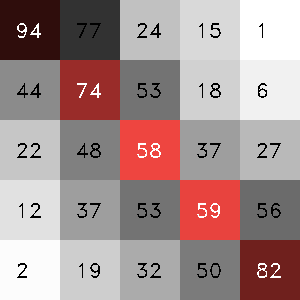

In [0]:
test_matrix = confusion_matrix(count_true, count_predictions)

tp_color = np.array(img_colors.light_2)[[2, 1, 0]]
fn_color = np.array([255, 255, 255])
confusion_img = draw_confusion_matrix(test_matrix, 60, tp_color, fn_color)
cv2_imshow(confusion_img)

##### **Observations**

**Classification Problem**


---

CNN3 $\hspace{5mm}\rightarrow\hspace{5mm}$ Batch Normalization led to better results  
  
CNN2 $\hspace{5mm}\rightarrow\hspace{5mm}$ Deeper architecture led to slightly less generalization

In [0]:
models_dir = os.path.join(base_dir_drive, 'Models')

train_loss1 = np.load(os.path.join(models_dir, 'train_loss_cnn1.npy'))
test_loss1 = np.load(os.path.join(models_dir, 'test_loss_cnn1.npy'), allow_pickle=True)
test_acc1 = np.load(os.path.join(models_dir, 'test_acc_cnn1.npy'))

train_loss2 = np.load(os.path.join(models_dir, 'train_loss_cnn2.npy'))
test_loss2 = np.load(os.path.join(models_dir, 'test_loss_cnn2.npy'), allow_pickle=True)
test_acc2 = np.load(os.path.join(models_dir, 'test_acc_cnn2.npy'))

train_loss3 = np.load(os.path.join(models_dir, 'train_loss_cnn3.npy'))
test_loss3 = np.load(os.path.join(models_dir, 'test_loss_cnn3.npy'), allow_pickle=True)
test_acc3 = np.load(os.path.join(models_dir, 'test_acc_cnn3.npy'))

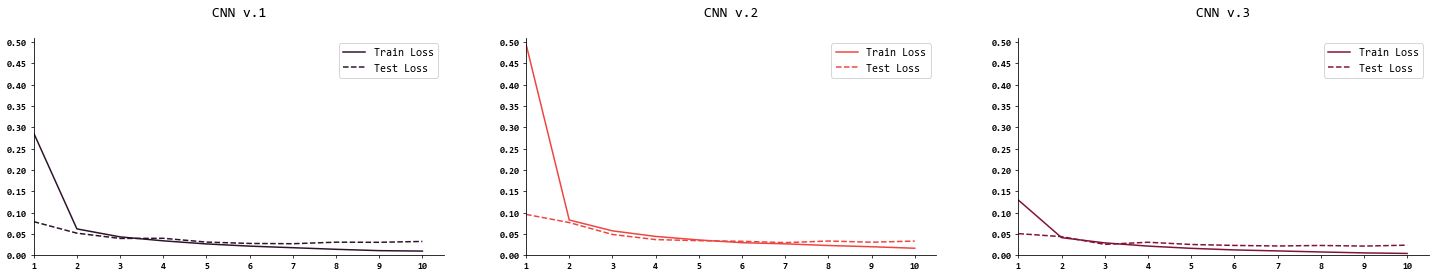

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(25, 4))

titles = ['CNN v.1', 'CNN v.2', 'CNN v.3']

loss_train1 = ax[0].plot(train_loss1, color=plot_colors.dark_2)
loss_test1 = ax[0].plot(test_loss1, color=plot_colors.dark_2, linestyle='--')
loss_train2 = ax[1].plot(train_loss2, color=plot_colors.light_2)
loss_test2 = ax[1].plot(test_loss2, color=plot_colors.light_2, linestyle='--')
loss_train3 = ax[2].plot(train_loss3[:10], color=plot_colors.middle)
loss_test3 = ax[2].plot(test_loss3[:10], color=plot_colors.middle, linestyle='--')

for i in range(3):
  ax[i].spines["top"].set_visible(False)
  ax[i].spines["right"].set_visible(False)

  ax[i].set_xlim([0, 9.5])
  x_ticks = list(range(10))
  ax[i].set_xticks(x_ticks)
  ax[i].set_xticklabels([t+1 for t in x_ticks], fontproperties=text_font)

  ylim = [0, .51]
  y_ticks = np.arange(ylim[0], ylim[1], .05)
  ax[i].set_ylim(ylim)
  ax[i].set_yticks(y_ticks)
  ax[i].set_yticklabels([str('{:1.2f}'.format(tick)) for tick in y_ticks],
                     fontproperties=text_font)
  ax[i].tick_params(axis='both', color='black', length=3, width=.75)
  legend = ax[i].legend(['Train Loss', 'Test Loss'], prop=labels_font)
  title = ax[i].set_title(titles[i] + '\n',
                    fontproperties=title_fontL)

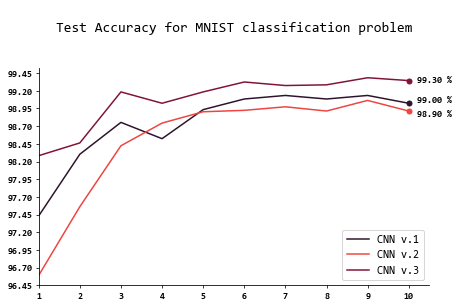

In [0]:
fig = plt.figure(figsize=(7, 4))
ax = plt.axes()

acc_test1 = plt.plot(test_acc1, color=plot_colors.dark_2)
acc_test2 = plt.plot(test_acc2, color=plot_colors.light_2)
acc_test3 = plt.plot(test_acc3[:10], color=plot_colors.middle)

ax.plot(9, test_acc1[-1], marker='o',markersize=5,
        markerfacecolor=plot_colors.dark_2, markeredgecolor=plot_colors.dark_2)
ax.plot(9, test_acc2[-1], marker='o',markersize=5,
        markerfacecolor=plot_colors.light_2, markeredgecolor=plot_colors.light_2)
ax.plot(9, test_acc3[9], marker='o',markersize=5,
        markerfacecolor=plot_colors.middle, markeredgecolor=plot_colors.middle)

ax.text(9.2, test_acc1[-1]+.05, '{:.1f}0 %'.format(test_acc1[-1]), 
        fontproperties=text_font, verticalalignment='center')
ax.text(9.2, test_acc2[-1]-.05, '{:.1f}0 %'.format(test_acc2[-1]), 
        fontproperties=text_font, verticalalignment='center')
ax.text(9.2, test_acc3[9], '{:.1f}0 %'.format(test_acc3[9]), 
        fontproperties=text_font, verticalalignment='center')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim([0, 9.5])
x_ticks = list(range(10))
ax.set_xticks(x_ticks)
ax.set_xticklabels([t+1 for t in x_ticks], fontproperties=text_font)

ylim = ax.get_ylim()
y_ticks = np.arange(ylim[0], ylim[1], .25)
ax.set_yticks(y_ticks)
ax.set_yticklabels([str('{:1.2f}'.format(tick)) for tick in y_ticks],
                   fontproperties=text_font)
ax.tick_params(axis='both', color='black', length=3, width=.75)
legend = ax.legend(['CNN v.1', 'CNN v.2', 'CNN v.3'], prop=labels_font)
title = ax.set_title('\nTest Accuracy for MNIST classification problem\n\n',
                   fontproperties=title_fontL)

**Counting Problem**


---

CNN3 $\hspace{5mm}\rightarrow\hspace{5mm}$ Batch Normalization made choosing a threshold difficult


In [0]:
models_dir = os.path.join(base_dir_drive, 'Models')

fcnn1_acc = np.load(os.path.join(models_dir, 'test_acc_fcnn1.npy'))
fcnn2_acc = np.load(os.path.join(models_dir, 'test_acc_fcnn2.npy'))
fcnn3_acc = np.load(os.path.join(models_dir, 'test_acc_fcnn3.npy'))

count_true = count_test_set['no_count']
count_random = np.random.randint(1, 5, size = 1000)
correct_rand = np.equal(count_random, count_true)
num_correct_rand = sum(correct_rand)
rand_acc = 100 * num_correct_rand / 1000

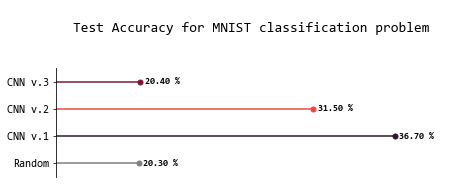

In [0]:
fig = plt.figure(figsize=(7, 2))
ax = plt.axes()

acc_test1 = plt.plot([0, fcnn1_acc], [1, 1], color=plot_colors.dark_2)
acc_test2 = plt.plot([0, fcnn2_acc], [2, 2], color=plot_colors.light_2)
acc_test3 = plt.plot([0, fcnn3_acc], [3, 3], color=plot_colors.middle)
acc_test3 = plt.plot([0, rand_acc], [0, 0], color='gray')

ax.plot(fcnn1_acc, 1, marker='o',markersize=5,
        markerfacecolor=plot_colors.dark_2, markeredgecolor=plot_colors.dark_2)
ax.plot(fcnn2_acc, 2, marker='o',markersize=5,
        markerfacecolor=plot_colors.light_2, markeredgecolor=plot_colors.light_2)
ax.plot(fcnn3_acc,  3, marker='o',markersize=5,
        markerfacecolor=plot_colors.middle, markeredgecolor=plot_colors.middle)
ax.plot(rand_acc,  0, marker='o',markersize=5,
        markerfacecolor='gray', markeredgecolor='gray')

ax.text(fcnn1_acc+.3, 1, '{:.1f}0 %'.format(fcnn1_acc), 
        fontproperties=text_font, verticalalignment='center')
ax.text(fcnn2_acc+.3, 2, '{:.1f}0 %'.format(fcnn2_acc), 
        fontproperties=text_font, verticalalignment='center')
ax.text(fcnn3_acc+.3, 3, '{:.1f}0 %'.format(fcnn3_acc), 
        fontproperties=text_font, verticalalignment='center')
ax.text(rand_acc+.3, 0, '{:.1f}0 %'.format(rand_acc), 
        fontproperties=text_font, verticalalignment='center')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_xlim([15, 40])
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylim([-.5, 3.5])
y_ticks = [0, 1, 2, 3]
ax.set_yticks(y_ticks)
ax.set_yticklabels(['Random', 'CNN v.1', 'CNN v.2', 'CNN v.3'],
                   fontproperties=labels_font)
ax.tick_params(axis='y', color='black', length=3, width=.75)
title = ax.set_title('\nTest Accuracy for MNIST ounting problem\n\n',
                   fontproperties=title_fontL)

## **Method 2** : Train a new convolutional network to predict the number of digits.

---


Designing a new convolutional network to directly predict the number of digits.  
  
Investigating the best network architecture for this task and the appropriate loss function (mean square error or cross-entropy).  

##### **Defining new CNN models**


---


Experiments for MNIST Counting CNN architecture  
<img src="https://drive.google.com/uc?id=1Co_96-r4hEUN-RALD-d-cf7ysfvZIJda" width=700 height=1100>



---


Defining the models.

In [0]:
class NewCNN1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, num_filters1, 5, 1)
    self.conv2 = nn.Conv2d(num_filters1, num_filters2, 5, 1)
    self.fully_conv1  = nn.Conv2d(num_filters2, num_neurons1, 4)
    self.fully_conv2 = nn.Conv2d(num_neurons1, 10, 1)
    self.fc1 = nn.Linear(10*19*19, 5)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.fully_conv1(x))
    x = F.relu(self.fully_conv2(x))
    x = x.view(-1, 10*19*19)
    x = self.fc1(x)
    return x

In [0]:
class NewCNN2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, num_filters1, 5, 1)
    self.conv2 = nn.Conv2d(num_filters1, num_filters2, 5, 1)
    self.fully_conv1  = nn.Conv2d(num_filters2, num_neurons1, 4)
    self.fully_conv2 = nn.Conv2d(num_neurons1, 10, 1)
    self.conv3 = nn.Conv2d(10, 16, 5, 1)
    self.fc1 = nn.Linear(16*7*7, 128)
    self.fc2 = nn.Linear(128, 5)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.fully_conv1(x))
    x = F.relu(self.fully_conv2(x))
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 16*7*7)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

Defining functions for training and testing

In [0]:
def train(args, model, device, train_loader, optimizer, epoch):
  batch_loss = []
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):

    data, target = data.to(device), target.to(device)
    target -= 1
    
    optimizer.zero_grad()
    
    output = model(data)
    
    loss = F.cross_entropy(output, target.long())
    
    loss.backward()
    batch_loss.append(loss.data.cpu().numpy())  
    
    optimizer.step()
      
  return np.array(batch_loss).mean()

def test(args, model, device, test_loader):
  model.eval()
  correct = 0
  test_loss = 0
  with torch.no_grad():
    num_iter = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      target -= 1
      
      output = model(data)
      
      test_loss += F.cross_entropy(output, target.long())
      
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).float().mean().item()
      num_iter += 1
  test_loss /= num_iter
    
  return test_loss, 100. * correct / num_iter

We will use the pretrained parameters from the FCNN model and initialize new CNN models. 

In [0]:
model_fcnn_state_dict = torch.load(os.path.join(base_dir_drive, 'Models/mnist_fcnn1.pt'))
print('    MNIST FCNN model :')
print('-'*30)
for name, param in model_fcnn_state_dict.items():
  print('%20s :   %15s' % (name, str(tuple(param.shape))))

    MNIST FCNN model :
------------------------------
        conv1.weight :     (20, 1, 5, 5)
          conv1.bias :             (20,)
        conv2.weight :    (50, 20, 5, 5)
          conv2.bias :             (50,)
  fully_conv1.weight :   (500, 50, 4, 4)
    fully_conv1.bias :            (500,)
  fully_conv2.weight :   (10, 500, 1, 1)
    fully_conv2.bias :             (10,)


In [0]:
model_transfer1 = NewCNN1()
trained_params = model_fcnn.state_dict().keys()

print(' New CNN1 - Trained Parameters Transfer')
print('-'*40)
for name, param in model_transfer1.named_parameters():
  if name in trained_params:
    param.data = model_fcnn.state_dict()[name]
    param.requires_grad = False

  print('%20s : %15s  |  requires_grad = %s' % 
        (name, str(tuple(param.shape)), param.requires_grad))

 New CNN1 - Trained Parameters Transfer
----------------------------------------
        conv1.weight :   (20, 1, 5, 5)  |  requires_grad = False
          conv1.bias :           (20,)  |  requires_grad = False
        conv2.weight :  (50, 20, 5, 5)  |  requires_grad = False
          conv2.bias :           (50,)  |  requires_grad = False
  fully_conv1.weight : (500, 50, 4, 4)  |  requires_grad = False
    fully_conv1.bias :          (500,)  |  requires_grad = False
  fully_conv2.weight : (10, 500, 1, 1)  |  requires_grad = False
    fully_conv2.bias :           (10,)  |  requires_grad = False
          fc1.weight :       (5, 3610)  |  requires_grad = True
            fc1.bias :            (5,)  |  requires_grad = True


In [0]:
model_transfer2 = NewCNN2()
trained_params = model_fcnn.state_dict().keys()

print(' New CNN2 - Trained Parameters Transfer')
print('-'*40)
for name, param in model_transfer2.named_parameters():
  if name in trained_params:
    param.data = model_fcnn.state_dict()[name]
    param.requires_grad = False

  print('%20s : %15s  |  requires_grad = %s' % 
        (name, str(tuple(param.shape)), param.requires_grad))

 New CNN2 - Trained Parameters Transfer
----------------------------------------
        conv1.weight :   (20, 1, 5, 5)  |  requires_grad = False
          conv1.bias :           (20,)  |  requires_grad = False
        conv2.weight :  (50, 20, 5, 5)  |  requires_grad = False
          conv2.bias :           (50,)  |  requires_grad = False
  fully_conv1.weight : (500, 50, 4, 4)  |  requires_grad = False
    fully_conv1.bias :          (500,)  |  requires_grad = False
  fully_conv2.weight : (10, 500, 1, 1)  |  requires_grad = False
    fully_conv2.bias :           (10,)  |  requires_grad = False
        conv3.weight :  (16, 10, 5, 5)  |  requires_grad = True
          conv3.bias :           (16,)  |  requires_grad = True
          fc1.weight :      (128, 784)  |  requires_grad = True
            fc1.bias :          (128,)  |  requires_grad = True
          fc2.weight :        (5, 128)  |  requires_grad = True
            fc2.bias :            (5,)  |  requires_grad = True




---


We will also train a model from scratch.

In [0]:
model_new1 = NewCNN2()

print(' New CNN3')
print('-'*10)
for name, param in model_new1.named_parameters():
  print('%20s : %15s  |  requires_grad = %s' % 
        (name, str(tuple(param.shape)), param.requires_grad))

 New CNN3
----------
        conv1.weight :   (20, 1, 5, 5)  |  requires_grad = True
          conv1.bias :           (20,)  |  requires_grad = True
        conv2.weight :  (50, 20, 5, 5)  |  requires_grad = True
          conv2.bias :           (50,)  |  requires_grad = True
  fully_conv1.weight : (500, 50, 4, 4)  |  requires_grad = True
    fully_conv1.bias :          (500,)  |  requires_grad = True
  fully_conv2.weight : (10, 500, 1, 1)  |  requires_grad = True
    fully_conv2.bias :           (10,)  |  requires_grad = True
        conv3.weight :  (16, 10, 5, 5)  |  requires_grad = True
          conv3.bias :           (16,)  |  requires_grad = True
          fc1.weight :      (128, 784)  |  requires_grad = True
            fc1.bias :          (128,)  |  requires_grad = True
          fc2.weight :        (5, 128)  |  requires_grad = True
            fc2.bias :            (5,)  |  requires_grad = True


In [0]:
model_transfer1.to(device)  
model_transfer2.to(device)
model_new1.to(device)  

optimizer_t1 = optim.SGD(model_transfer1.parameters(), lr=.001, momentum=args.momentum)
optimizer_t2 = optim.SGD(model_transfer2.parameters(), lr=.001, momentum=args.momentum)
optimizer_n1 = optim.SGD(model_new1.parameters(), lr=.01, momentum=args.momentum)

train_total_loss = []
test_total_loss = []
test_accuracy = []

for epoch in range(0, 41):
  print('\nEPOCH  %2d :' % (epoch+1))
  print('-'*15)

  train_loss1 = train(args, model_transfer1, device, count_dataloader_train, optimizer_t1, epoch)
  test_loss1, epoch_acc1 = test(args, model_transfer1, device, count_dataloader_test)
  print('  Pretrained model 1 | Train Loss     %.4f' % train_loss1)
  print('                       Test Loss      %.4f' % test_loss1)
  print('                       Test Accuracy  %.4f' % epoch_acc1)

  train_loss2 = train(args, model_transfer2, device, count_dataloader_train, optimizer_t2, epoch)
  test_loss2, epoch_acc2 = test(args, model_transfer2, device, count_dataloader_test)
  print('  Pretrained model 2 | Train Loss     %.4f' % train_loss2)
  print('                       Test Loss      %.4f' % test_loss2)
  print('                       Test Accuracy  %.4f' % epoch_acc2)

  train_loss3 = train(args, model_new1, device, count_dataloader_train, optimizer_n1, epoch)
  test_loss3, epoch_acc3 = test(args, model_new1, device, count_dataloader_test)
  print('       Scratch model | Train Loss     %.4f' % train_loss3)
  print('                       Test Loss      %.4f' % test_loss3)
  print('                       Test Accuracy  %.4f' % epoch_acc3)

  train_total_loss.append([train_loss1, train_loss2, train_loss3])
  test_total_loss.append([test_loss1, test_loss2, test_loss3])
  test_accuracy.append([epoch_acc1, epoch_acc2, epoch_acc3])

torch.save(model_transfer1.state_dict(), 
           os.path.join(base_dir_drive, 'Models/new_cnn1_t1.pt'))
torch.save(model_transfer2.state_dict(), 
           os.path.join(base_dir_drive, 'Models/new_cnn2_t2.pt'))  
torch.save(model_new1.state_dict(), 
           os.path.join(base_dir_drive, 'Models/new_cnn2_no_t.pt'))


EPOCH   1 :
---------------
  Pretrained model 1 | Train Loss     2.3951
                       Test Loss      2.5042
                       Test Accuracy  32.6953
  Pretrained model 2 | Train Loss     1.6201
                       Test Loss      1.6050
                       Test Accuracy  21.2891
       Scratch model | Train Loss     1.6095
                       Test Loss      1.6086
                       Test Accuracy  21.7773

EPOCH   2 :
---------------
  Pretrained model 1 | Train Loss     1.8035
                       Test Loss      2.2542
                       Test Accuracy  34.1211
  Pretrained model 2 | Train Loss     1.5778
                       Test Loss      1.5864
                       Test Accuracy  24.5313
       Scratch model | Train Loss     1.6096
                       Test Loss      1.6084
                       Test Accuracy  21.7773

EPOCH   3 :
---------------
  Pretrained model 1 | Train Loss     1.4630
                       Test Loss      2.3732
       

##### **Evaluating the results**

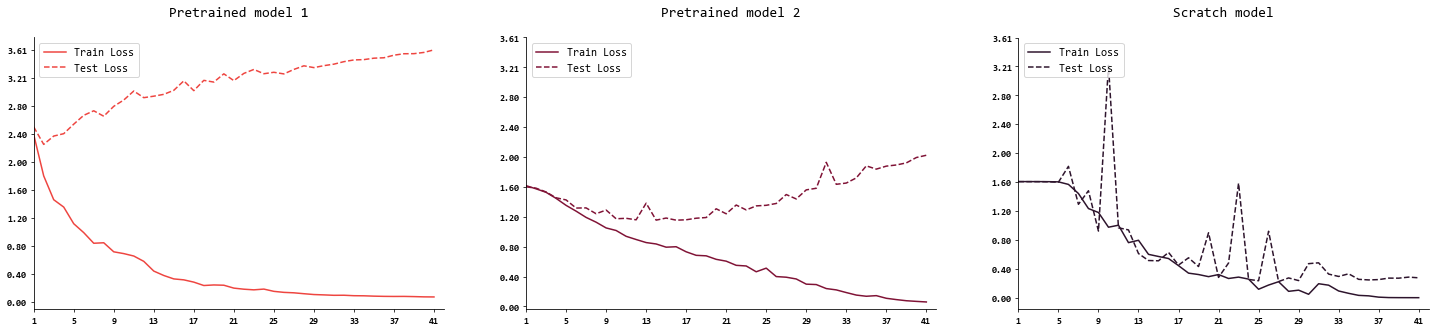

In [0]:
train_total_loss = np.array(train_total_loss)
test_total_loss = np.array(test_total_loss)

fig, ax = plt.subplots(1, 3, figsize=(25, 5))

train_min, train_max = np.min(train_total_loss), np.max(train_total_loss)
test_min, test_max = np.min(test_total_loss), np.max(test_total_loss)
y_ticks = np.linspace(min(train_min, test_min), max(train_max, test_max).cpu(), 10)

titles = ['Pretrained model 1', 'Pretrained model 2', 'Scratch model']

colors = [plot_colors.light_2, plot_colors.middle, plot_colors.dark_2]
for m in range(3):

  ax[m].plot(train_total_loss[:, m], color=colors[m], linestyle='-')
  ax[m].plot(test_total_loss[:, m], color=colors[m], linestyle='--')

  ax[m].spines["top"].set_visible(False)
  ax[m].spines["right"].set_visible(False)

  ax[m].set_xlim([0, 41])
  x_ticks = np.arange(0, 41, 4)
  ax[m].set_xticks(x_ticks)
  ax[m].set_xticklabels([t+1 for t in x_ticks], fontproperties=text_font)

  ax[m].set_yticks(y_ticks)
  ax[m].set_yticklabels(['{:.2f}'.format(t) for t in y_ticks],
                        fontproperties=text_font)
  
  ax[m].tick_params(axis='both', color='black', length=3, width=.75)
  legend = ax[m].legend(['Train Loss', 'Test Loss'], prop=labels_font,
                        loc='upper left')
  title = ax[m].set_title(titles[m] + '\n', fontproperties=title_fontL)
  

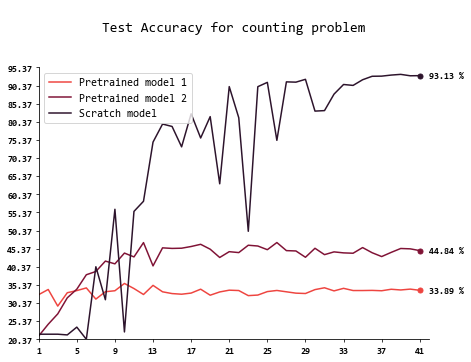

In [0]:
test_accuracy = np.array(test_accuracy)
min_acc, max_acc = np.min(test_accuracy), np.max(test_accuracy)

fig= plt.figure(figsize=(7, 5))
ax = plt.axes()

legends = ['Pretrained model 1', 'Pretrained model 2', 'Scratch model']
plots = []

for m in range(3):

  acc, = ax.plot(test_accuracy[:, m], color=colors[m])
  plots.append(acc)
  ax.plot(40, test_accuracy[-1, m], marker='o',markersize=5,
          markerfacecolor=colors[m], markeredgecolor=colors[m])  
  ax.text(41, test_accuracy[-1, m], '{:.2f} %'.format(test_accuracy[-1, m]), 
          fontproperties=text_font, verticalalignment='center')

  
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim([0, 41])
x_ticks = np.arange(0, 41, 4)
ax.set_xticks(x_ticks)
ax.set_xticklabels([t+1 for t in x_ticks], fontproperties=text_font)

ax.set_ylim([min_acc, max_acc])
y_ticks = np.arange(min_acc, max_acc+3, 5)
ax.set_yticks(y_ticks)
ax.set_yticklabels(['{:.2f}'.format(t) for t in y_ticks],
                        fontproperties=text_font)

ax.tick_params(axis='both', color='black', length=3, width=.75)

legend = ax.legend(plots, legends, prop=labels_font, loc='upper left')
title = ax.set_title('\nTest Accuracy for counting problem\n\n',
                   fontproperties=title_fontL)

##### **Observations**

**Pretrained models:**

---

The deeper architecture gave best results on the test set.  
The test losses on both model increased over training, while the train losses decreased, but the test loss on the deeper model increased less.



**Scratch model:**


---

The scratch model gave the best result, with an accuracy more than double comparing to the best pretrained model.

**Conclusion:**

---


More parameters to be learned $\bf{\hspace{5mm}\Rightarrow\hspace{5mm}}$Increased accuracy  